In [1]:
from genetic_algorithm import algorithms, selectors, individuals, crossover
from deap import base, creator, tools
import numpy as np
import random

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", individuals.truss_like, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)])))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mutate", lambda ind: ind.mutate())
toolbox.register("mate", crossover.mix_crossover)
toolbox.register("select", selectors.select_individuals_elitist)

n_pop = 50
pop = toolbox.population(n=n_pop)

hall_of_fame = tools.HallOfFame(1)

# Definir estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


population, logbook = algorithms.ea(pop, toolbox, 100, halloffame= hall_of_fame, stats= stats)

pm:2.2:  99%|█████████▉| 99/100 [02:46<00:00,  1.13it/s] c:\Users\ijara\OneDrive\Documentos\GitHub\py_BandGap\genetic_algorithm\probabilities.py:14: RuntimeWarning: divide by zero encountered in divide
  p = lambda f : 0.3 * np.divide(num, den)
c:\Users\ijara\OneDrive\Documentos\GitHub\py_BandGap\genetic_algorithm\probabilities.py:14: RuntimeWarning: invalid value encountered in divide
  p = lambda f : 0.3 * np.divide(num, den)
pm:2.0: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


Estructura formada por aluminio (azul) y tungsteno (rojo)

Las barras son de 4 y 8 mm de diámetro

In [ ]:
best_individual = hall_of_fame[0]
print(f'bandgap:{best_individual.bandgap:.3f} kHz')
best_individual.plot()


NameError: name 'best_individual' is not defined

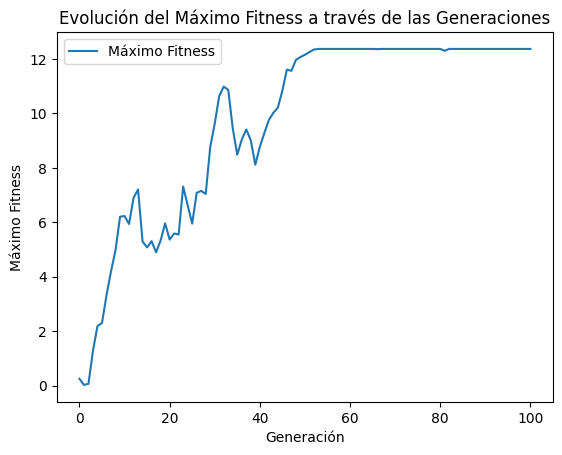

In [ ]:
import matplotlib.pyplot as plt
gen, max = logbook.select("gen", "avg")

plt.plot(gen, max, label="Máximo Fitness")
plt.xlabel("Generación")
plt.ylabel("Máximo Fitness")
plt.title("Evolución del Máximo Fitness a través de las Generaciones")
plt.legend()
plt.show()

In [ ]:
print(logbook)      

gen	nevals	pm  	avg      	std        	min      	max     
0  	50    	    	0.253247 	0.511251   	0.01     	1.83807 
1  	49    	5   	0.0270272	0.0390919  	0.01     	0.127088
2  	48    	6.1 	0.0676231	0.277577   	0.01     	1.42738 
3  	47    	6.7 	1.28199  	1.69389    	0.01     	5.04214 
4  	44    	8   	2.19254  	1.64343    	0.01     	5.88701 
5  	49    	9   	2.30143  	2.07884    	0.01     	6.00053 
6  	44    	6.1 	3.3175   	1.54163    	0.538459 	6.42858 
7  	46    	7.6 	4.1981   	2.19746    	0.01     	6.66799 
8  	45    	8.4 	4.9747   	2.35783    	0.0207853	7.74434 
9  	47    	10.2	6.20514  	1.30786    	2.18161  	8.93762 
10 	50    	9.5 	6.23074  	2.1253     	2.55092  	10.0832 
11 	47    	10.8	5.93792  	2.25855    	0.01     	10.0832 
12 	49    	10.4	6.89783  	2.09557    	2.01664  	10.6995 
13 	48    	9.9 	7.2052   	2.08447    	2.77485  	10.0832 
14 	50    	13.3	5.29212  	1.62312    	2.62248  	9.3533  
15 	50    	13.9	5.07697  	2.21968    	0.01     	9.17236 
16 	49    	13.8	5.30724  	1.833